In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets

# MNIST

In [135]:
class MNISTClassifier(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.1)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
    
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.fc5(x)
        return x

In [136]:
def get_best_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


# load model
state_dict = torch.load("mnist_state_dict.pt", map_location = get_best_device())
model = MNISTClassifier()
model.load_state_dict(state_dict)

/tmp/ipykernel_280824/3315047612.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("mnist_state_dict.pt", map_location = get_best_device())


<All keys matched successfully>

In [137]:
# define dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.5, ))
])

dataset = datasets.MNIST(root='./mnist_data', train=False, transform=transform, download=True)
loader = DataLoader(dataset, shuffle=True, batch_size=1)

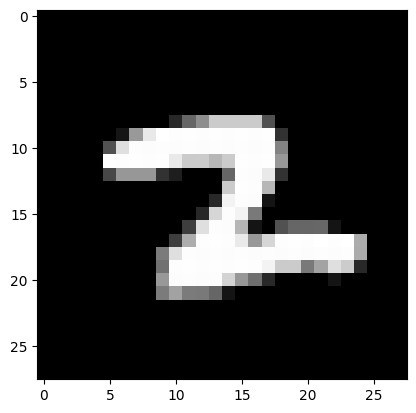

In [138]:
import matplotlib.pyplot as plt

def visualize_mnist_image(img):
    img = img.view(784)
    np_img = img.numpy()
    mat = np_img.reshape(28, 28)
    plt.imshow(mat, cmap='grey')

visualize_mnist_image(x)

In [171]:
def run_mnist_fgsm(model, x, y, epsilon=[0.1]):
    
    model.eval()
    device = next(model.parameters()).device
    
    x = x.view(-1, 784).detach()
    x= x.to(device)
    y = y.to(device)
    x.requires_grad = True
    
    out = model(x) 
    
    loss = F.cross_entropy(out, y)
    loss.backward()
    
    if not isinstance(epsilon, list):
        epsilon = [epsilon]
    
    num_epsilon = len(epsilon)
    epsilon = torch.tensor(epsilon) # len
    epsilon = epsilon.view(num_epsilon , -1)
    
    
    mod_x = x + (x.grad * epsilon)
    mod_x = mod_x.detach()
    
    return mod_x

In [172]:
x,y = next(iter(loader))
mod_x = run_mnist_fgsm(model, x, y, [0.05, 0.1, 0.2, 0.3, 1000])
print(mod_x.shape)

torch.Size([5, 784])


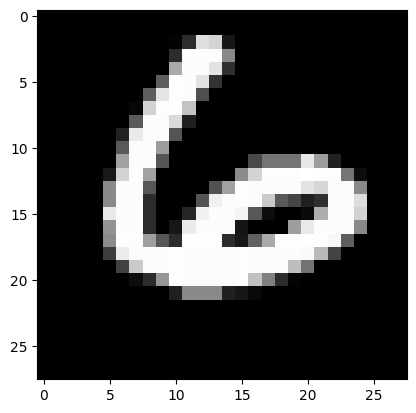

In [175]:
visualize_mnist_image(mod_x[1, :])

# ImageNet